# Find the unfair clauses

In [1]:
import pandas as pd
from numpy.random import RandomState
import numpy as np
import re
import string
from nltk.corpus import stopwords 
from sklearn import preprocessing
from nltk.tokenize import word_tokenize 
import spacy as spacy
from time import time

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from keras.layers import Embedding

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils import resample
import matplotlib.pyplot as plt
import itertools

import tensorflow.keras.backend as K
import tensorflow as tf
import os

Using TensorFlow backend.


In [2]:
class FairnessClassifierCNN(object):
    
    def __init__(self):
        self.df = pd.read_csv('../datasets/UnfairClauseClassifierDataset.csv')
        self.df = self.df.replace(-1, 0)
        self.df = self.df[['Sentences', 'Labels']]
        
        self.NUM_WORDS = 5000
        self.tokenizer = Tokenizer(num_words=self.NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)

        self.EMBEDDING_DIM = 300
        
    def clean_text(self):
        self.df['Text_Clean'] = self.df['Sentences'].apply(lambda x: self.remove_punct(x))
        tokens = [word_tokenize(sen) for sen in self.df.Text_Clean]
        lower_tokens = [self.lower_token(token) for token in tokens]
        filtered_words = [self.removeStopWords(sen) for sen in lower_tokens]
        self.df['Text_Final'] = [' '.join(sen) for sen in filtered_words]
        self.df['tokens'] = filtered_words 
        self.preprocess_text()
        
        self.df.Sentences = self.df.Text_Final       
        self.df = self.df[['Sentences', 'tokens', 'Labels']]
        
    def upsample_and_split(self):
        df_fair = self.df[self.df.Labels==0]
        df_unfair = self.df[self.df.Labels==1]
        
        df_unfair_upsampled = resample(df_unfair,
                                      replace=True,
                                      n_samples=len(df_fair.index),
                                      random_state=43)
        self.df = pd.concat([df_fair, df_unfair_upsampled])
        
        X = self.df.Sentences
        y = self.df.Labels
                
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.35, random_state=RandomState())
        
    def preprocess_text(self):
        nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
        brief_cleaning = (re.sub("[^A-Za-z]+", ' ', str(row)).lower() for row in self.df['Sentences'])
        t = time()
        txt = [self.cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]
        print('Time taken to cleanup everything: {} mins'.format(round((time() - t)/60, 2)))
    
    def cleaning(self, doc):
        txt = [token.lemma_ for token in doc if not token.is_stop]
        if len(txt) > 2:
            return ' '.join(txt)

    def remove_punct(self, text):
        text_nopunct = ''
        text_nopunct = re.sub('['+string.punctuation+']', '', text)
        text_nopunct = re.sub(r'\s+', ' ', text_nopunct)
        text_nopunct = re.sub(r'\d+', '', text_nopunct)  #remove numbers
        text_nopunct = text_nopunct.strip()  #remove whitespaces
        return text_nopunct
    
    def lower_token(self, tokens): 
        return [w.lower() for w in tokens]   
    
    def removeStopWords(self, tokens): 
        stoplist = stopwords.words('english')
        return [word for word in tokens if word not in stoplist]
    
    def text_to_sequence(self):
        self.tokenizer.fit_on_texts(self.df.Sentences)
        sequences_train = self.tokenizer.texts_to_sequences(self.X_train)
        sequences_test = self.tokenizer.texts_to_sequences(self.X_test)
       
        vocab_size = len(self.tokenizer.word_index) + 1
        self.maxlen = max([len(s.split()) for s in self.df.Sentences])
        
        self.X_train = pad_sequences(sequences_train, padding='post', maxlen=self.maxlen)                  
        self.X_test = pad_sequences(sequences_test, padding='post', maxlen=self.maxlen)
        
        self.y_train = to_categorical(np.asarray(self.y_train))
        self.y_test = to_categorical(np.asarray(self.y_test))
    
        print('Shape of X train tensor:', self.X_train.shape)
        print('Shape of y train tensor:', self.y_train.shape)
        print('Shape of X test tensor:', self.X_test.shape)
        print('Shape of y test tensor:', self.y_test.shape)

        return vocab_size
    
    def word_to_vec(self, vocab_size):
        word_vectors = KeyedVectors.load_word2vec_format('../models/w2v_fair_model.bin', binary=True)

        embedding_matrix = np.zeros((vocab_size, self.EMBEDDING_DIM))

        for word, i in self.tokenizer.word_index.items():
            if i >= self.NUM_WORDS:
                continue
            try:
                embedding_vector = word_vectors[word]
                embedding_matrix[i] = embedding_vector
            except KeyError:
                embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), self.EMBEDDING_DIM)
                
        nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
        print(nonzero_elements/vocab_size)

        del(word_vectors)

        embedding_layer = Embedding(vocab_size, self.EMBEDDING_DIM, weights=[embedding_matrix], trainable=True)
        return embedding_layer

    def build_model(self, embedding_layer):
        filter_sizes = [3, 3, 3, 3]
        num_filters = 32

        inputs = Input(shape=(self.maxlen,))
        embedding = embedding_layer(inputs)
        reshape = Reshape((self.maxlen, self.EMBEDDING_DIM, 1))(embedding)

        conv_0 = Conv2D(num_filters, (filter_sizes[0], self.EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
        conv_1 = Conv2D(num_filters, (filter_sizes[1], self.EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
        conv_2 = Conv2D(num_filters, (filter_sizes[2], self.EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
        conv_3 = Conv2D(num_filters, (filter_sizes[3], self.EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
        
        maxpool_0 = MaxPooling2D((self.maxlen - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
        maxpool_1 = MaxPooling2D((self.maxlen - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)
        maxpool_2 = MaxPooling2D((self.maxlen - filter_sizes[2] + 1, 1), strides=(1,1))(conv_2)
        maxpool_3 = MaxPooling2D((self.maxlen - filter_sizes[3] + 1, 1), strides=(1,1))(conv_3)

        merged_tensor = concatenate([maxpool_0, maxpool_1, maxpool_2], axis=1)
        flatten = Flatten()(merged_tensor)
        reshape = Reshape((3*num_filters,))(flatten)
#         dropout = Dropout(0.5)(reshape)
        output = Dense(units=2, activation='sigmoid')(reshape)
        return inputs, output

    def train_model(self, inputs, output):
        model = Model(inputs, output)
        adam = Adam(lr=1e-3)
        sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc'])
        print(model.summary())
        callback_checkpoint = ModelCheckpoint("fairness_model_weights.h5", verbose=1, save_best_only=True, monitor='val_loss')
        callbacks = [
            EarlyStopping(patience=5, monitor='val_loss'),
            callback_checkpoint
        ]
        history = model.fit(self.X_train, self.y_train, batch_size=16, epochs=10, verbose=1, 
                            validation_split=0.3, callbacks=callbacks, class_weight={0:1, 1:1})
        return history, model
    
    def evaluate_model(self, history, model):
        loss, acc = model.evaluate(self.X_test, self.y_test, verbose = 1, batch_size=1024)
        print("Test Accuracy: {:.4f}".format(acc*100))
     
        y_pred = model.predict(self.X_test)
        y_pred[y_pred>=0.5] = 1
        y_pred[y_pred<0.5] = 0
        
        print("ROC_AUC_SCORE: ",roc_auc_score(self.y_test, y_pred))
    
        target_names = ['Fair', 'Unfair']
        
        print(classification_report(self.y_test, y_pred, target_names = target_names, zero_division='warn'))
        
        cnf_matrix = confusion_matrix(self.y_test.argmax(axis=1), y_pred.argmax(axis=1), labels=[0, 1])
        np.set_printoptions(precision=2)
        plt.figure()
        self.plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')

        plt.figure(figsize=(20,10))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.show()
        
    def plot_confusion_matrix(self, cm, classes=['Fair', 'Unfair'], normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
    def predict(self, model):
        model.load_weights("fairness_model_weights.h5")
        predictions = model.predict(np.expand_dims(self.X_test[50], 0))
        print(self.tokenizer.sequences_to_texts([self.X_test[50]]))
        print(self.y_test[50])
        print(predictions)
   
    def getmaxlen(self): 
        return self.maxlen

In [3]:
def main():
    np.set_printoptions(threshold=np.inf)
    fairness_classifier = FairnessClassifierCNN()
    fairness_classifier.clean_text()
    fairness_classifier.upsample_and_split()
    word_index = fairness_classifier.text_to_sequence()
    embedding_layer = fairness_classifier.word_to_vec(word_index)
    inputs, output = fairness_classifier.build_model(embedding_layer)
    history, model = fairness_classifier.train_model(inputs, output)
    fairness_classifier.evaluate_model(history, model)
    fairness_classifier.predict(model)
    with open('../models/FairnessClassifier.json', "w") as json_file:
        json_file.write(model.to_json())        

Time taken to cleanup everything: 0.19 mins
Shape of X train tensor: (10896, 241)
Shape of y train tensor: (10896, 2)
Shape of X test tensor: (5868, 241)
Shape of y test tensor: (5868, 2)
0.7351470588235294
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 241)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 241, 300)     2040000     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 241, 300, 1)  0           embedding_1[0][0]                
___________________________________________________________________________________

D:\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7627 samples, validate on 3269 samples
Epoch 1/10
7627/7627 [==============================] - 47s 6ms/step - loss: 0.5286 - acc: 0.7998 - val_loss: 0.4577 - val_acc: 0.8623

Epoch 00001: val_loss improved from inf to 0.45768, saving model to fairness_model_weights.h5
Epoch 2/10
7627/7627 [==============================] - 44s 6ms/step - loss: 0.3894 - acc: 0.9027 - val_loss: 0.4036 - val_acc: 0.8984

Epoch 00002: val_loss improved from 0.45768 to 0.40356, saving model to fairness_model_weights.h5
Epoch 3/10
7627/7627 [==============================] - 45s 6ms/step - loss: 0.3474 - acc: 0.9272 - val_loss: 0.3712 - val_acc: 0.9136

Epoch 00003: val_loss improved from 0.40356 to 0.37122, saving model to fairness_model_weights.h5
Epoch 4/10
7627/7627 [==============================] - 47s 6ms/step - loss: 0.3193 - acc: 0.9430 - val_loss: 0.3583 - val_acc: 0.9202

Epoch 00004: val_loss improved from 0.37122 to 0.35835, saving model to fairness_model_weights.h5
Epoch 5/10
7627/7627

D:\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[2542  408]
 [ 107 2811]]


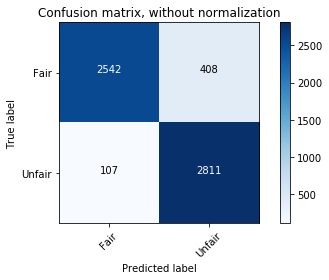

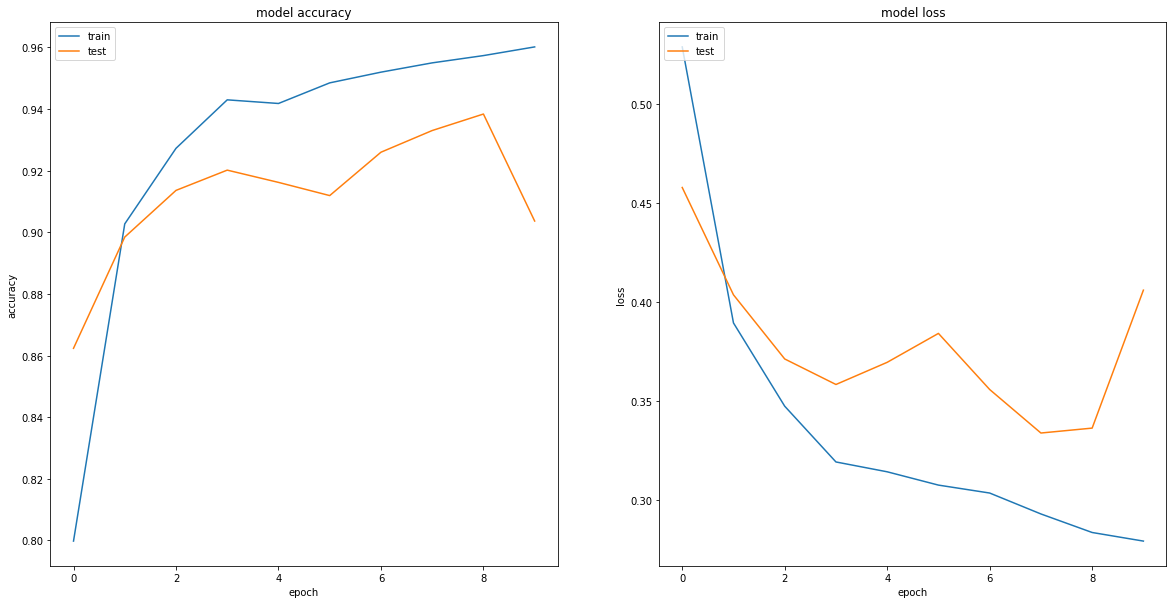

['company intellectual property policy lrb rrb remove disable access material company believes good faith upon notice intellectual property owner agent infringing intellectual property third party made available service lrb ii rrb remove user content uploaded service repeat infringers']
[0. 1.]
[[0.01 0.99]]


In [4]:
if __name__=="__main__": main()

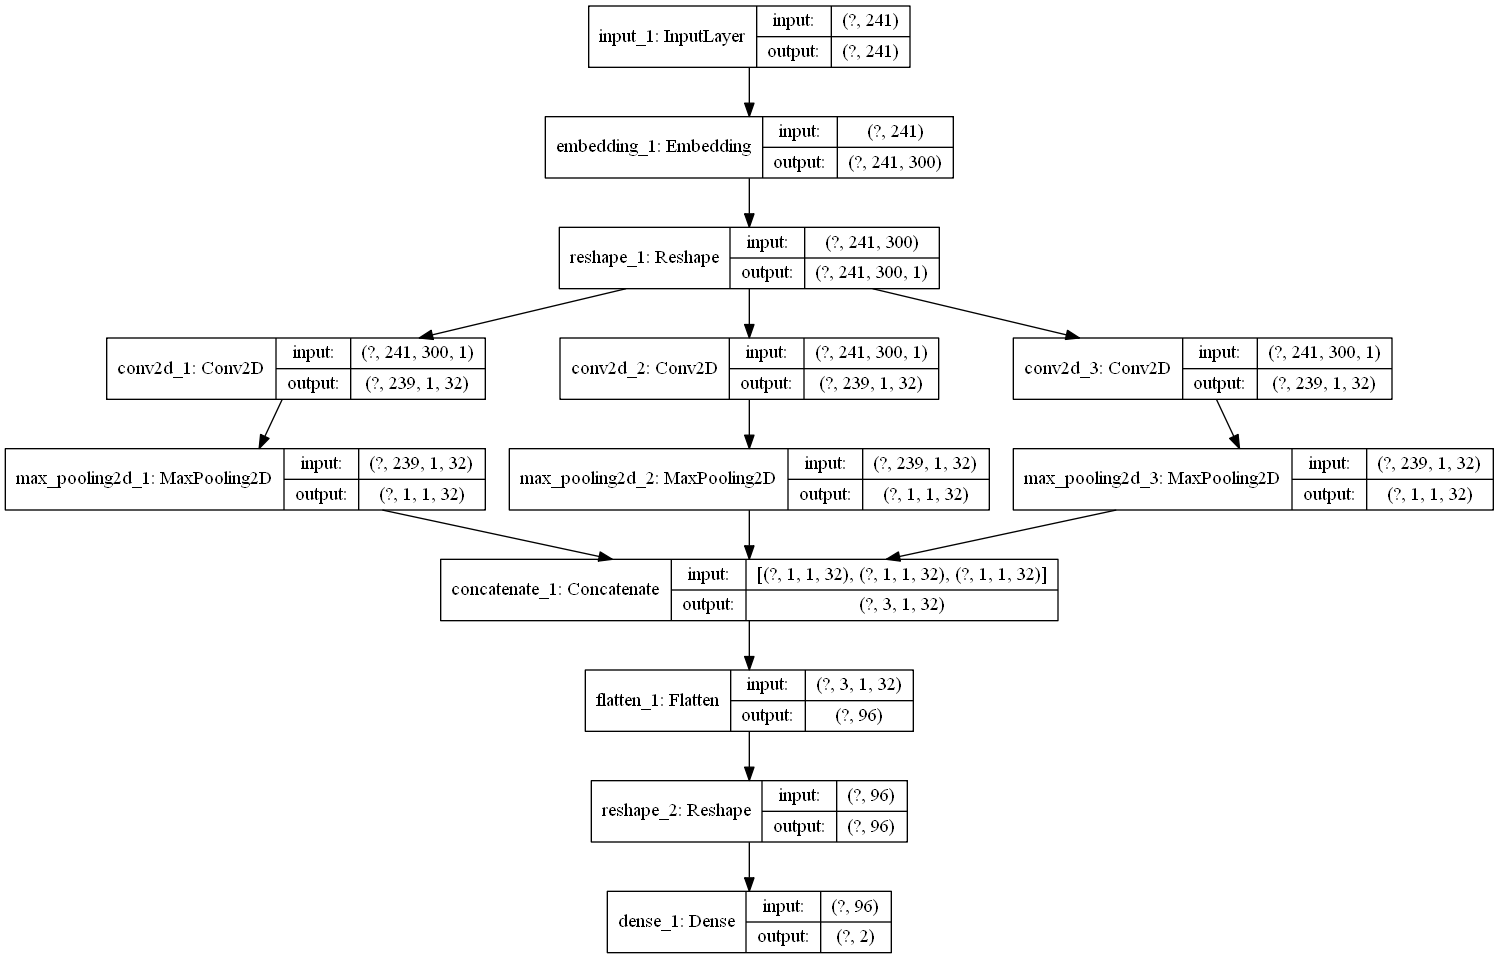

In [2]:
from keras.models import model_from_json
from tensorflow.keras.utils import plot_model
with open("../models/FairnessClassifier.json", "r") as f:
    data = f.read()
    model = model_from_json(data)
model.load_weights("fairness_model_weights.h5")
plot_model(model, to_file='fairness_model.png', show_shapes=True, show_layer_names=True)